In [ ]:
import seisbench
import seisbench.data as sbd
import seisbench.models as sbm
import seisbench.generate as sbg
import seisbench.util as sbu
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as ex
import plotly.graph_objects as go
from obspy.clients.fdsn.header import FDSNException
from pathlib import Path
import requests
from obspy.core.event import read_events
import os
import scipy.signal as signal
from scipy.signal import butter, filtfilt
client = Client('IRIS')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [ ]:
data = sbd.WaveformDataset('/content/drive/MyDrive/NASA_challenge/data_v2' , cache = 'full')

2024-10-04 15:35:11,113 | seisbench | WARNING | Data set contains mixed sampling rate, but no sampling rate was specified for the dataset.get_waveforms will return mixed sampling rate waveforms.
2024-10-04 15:35:11,127 | seisbench | WARNING | Output component order not specified, defaulting to 'ZNE'.


In [ ]:
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    Applies a bandpass Butterworth filter to the input data.

    Parameters:
    - data: Input signal (1D array)
    - lowcut: Low cutoff frequency for the bandpass filter in Hz
    - highcut: High cutoff frequency for the bandpass filter in Hz
    - fs: Sampling frequency in Hz
    - order: The order of the filter (default is 4)

    Returns:
    - filtered_data: Bandpass-filtered signal (1D array)
    """
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    print(low,high)
    # Design Butterworth bandpass filter
    b, a = butter(order, [low, high], btype='band')

    # Apply the filter using filtfilt to prevent phase distortion
    filtered_data = filtfilt(b, a, data)

    return filtered_data

In [ ]:
def highpass_filter(data, cutoff, fs, order=4):
    """
    Applies a highpass Butterworth filter to the input data.

    Parameters:
    - data: Input signal (1D array)
    - cutoff: Cutoff frequency for the highpass filter in Hz
    - fs: Sampling frequency in Hz
    - order: The order of the filter (default is 4)

    Returns:
    - filtered_data: Highpass-filtered signal (1D array)
    """
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist

    # Design Butterworth highpass filter
    b, a = butter(order, normal_cutoff, btype='high')

    # Apply the filter using filtfilt to prevent phase distortion
    filtered_data = filtfilt(b, a, data)

    return filtered_data

In [ ]:
def get_filtered(sig,highpass_cut=1, bandpass_lowcut= .1,bandpass_highcut =1.5, band_filt = True,high_filt=True):

    # Apply the high-pass filter to remove frequencies below 0.5 Hz
    filtered_trace = signal.detrend(sig)
    filtered_trace = signal.medfilt(filtered_trace, kernel_size=21)
    if high_filt:
        filtered_trace = highpass_filter(sig, highpass_cut, fs=20)
    if band_filt:
        filtered_trace = bandpass_filter(sig, bandpass_lowcut, bandpass_highcut,fs=20)


    return filtered_trace

In [ ]:
number_trace = 66
filtered_trace0 =  get_filtered(data.get_waveforms(number_trace)[0].T [0:10000],
                                highpass_cut =.5,
                         #      bandpass_lowcut= .01,
                         #       bandpass_highcut =1,
                                band_filt=False)
filtered_trace1 =  get_filtered(data.get_waveforms(number_trace)[1].T,highpass_cut =.5, band_filt=False)
filtered_trace2 =  get_filtered(data.get_waveforms(number_trace)[2].T,highpass_cut =.5, band_filt=False)

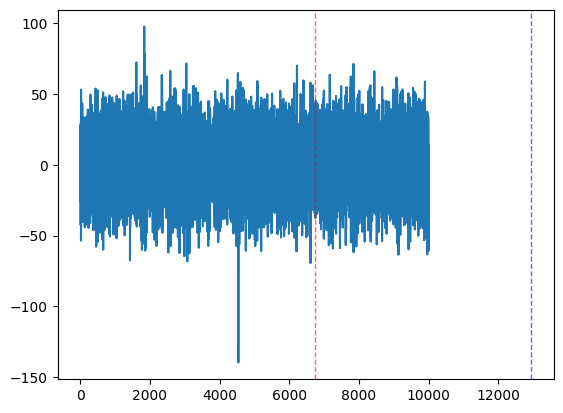

In [ ]:
plt.plot(filtered_trace0)
plt.axvline(x=(data.metadata.iloc[number_trace]['trace_Pg_arrival_sample']), color='red', linestyle='--', label=f'P arrival',lw=1,alpha = 0.6)
plt.axvline(x=(data.metadata.iloc[number_trace]['trace_Sg_arrival_sample']), color='blue', linestyle='--', label=f'S arrival',lw=1, alpha = .6)


In [ ]:
frequencies, times, Sxx_0 = signal.spectrogram(filtered_trace0, 20,nfft = 2048,nperseg=520 , noverlap = 124,scaling = 'density')
frequencies1, times1, Sxx_1 = signal.spectrogram(filtered_trace1, 20, nfft = 2048,nperseg=1024 , noverlap = 1024 *.75,scaling = 'density')
frequencies2, times2, Sxx_2 = signal.spectrogram(filtered_trace2, 20, nfft = 2048,nperseg=1024 , noverlap = 1024 *.75,scaling = 'density')

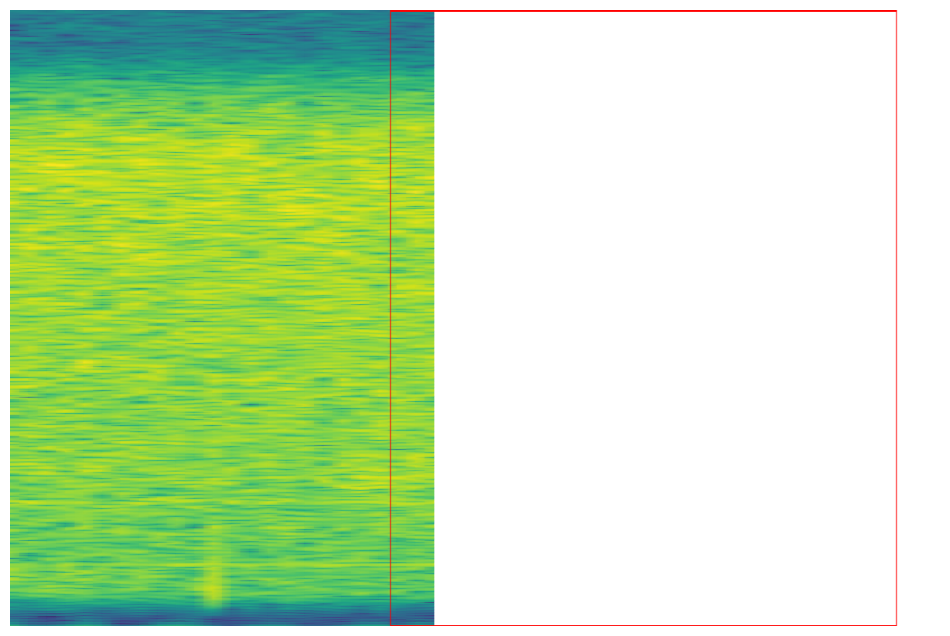

In [ ]:
import matplotlib.patches as patches

# Plot the spectrogram
fig, ax = plt.subplots(figsize = (12,8))


# Remove all spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.pcolormesh(times, frequencies, np.log10(Sxx_0), cmap= 'viridis',shading='gouraud')
ax.axvline(x=(data.metadata.iloc[number_trace]['trace_P_spectral_start_arrival_sample']/20), color='red', linestyle='-', label=f'P arrival',lw=1,alpha = 0.6)
ax.axvline(x=(data.metadata.iloc[number_trace]['trace_S_spectral_end_arrival_sample']/20), color='red', linestyle='-', label=f'S arrival',lw=1, alpha = .6)
# Define the y-limits of the box (these should be the vertical limits of the plot or as desired)
p_arrival = data.metadata.iloc[number_trace]['trace_P_spectral_start_arrival_sample'] / 20
s_arrival = data.metadata.iloc[number_trace]['trace_S_spectral_end_arrival_sample'] / 20
ymin, ymax = ax.get_ylim()
# Draw the top and bottom horizontal edges between P and S arrival times
ax.hlines(y=ymax, xmin=p_arrival, xmax=s_arrival, colors='red', linestyles='-', lw=2)
ax.hlines(y=ymin, xmin=p_arrival, xmax=s_arrival, colors='red', linestyles='-', lw=2)
plt.ylabel('')
plt.xlabel('')
plt.title('')
#plt.colorbar(label='Intensity [dB]')
plt.show()

In [ ]:
from scipy.signal import resample
target_sampling_rate = 20.0
resampled_waveforms = []

for i in range(len(data.metadata)):
    waveform = data.get_waveforms(i)[0]
    current_rate = data.metadata.iloc[i]['trace_sampling_rate_hz']

    if current_rate != target_sampling_rate:
        num_samples = int(len(waveform) * target_sampling_rate / current_rate)
        resampled_waveform = resample(waveform, num_samples)
        resampled_waveforms.append(resampled_waveform)
        print(f"Resampled waveform {i} from {current_rate} Hz to {target_sampling_rate} Hz")
    else:
        resampled_waveforms.append(waveform)

Resampled waveform 1 from 10.0 Hz to 20.0 Hz
Resampled waveform 2 from 10.0 Hz to 20.0 Hz


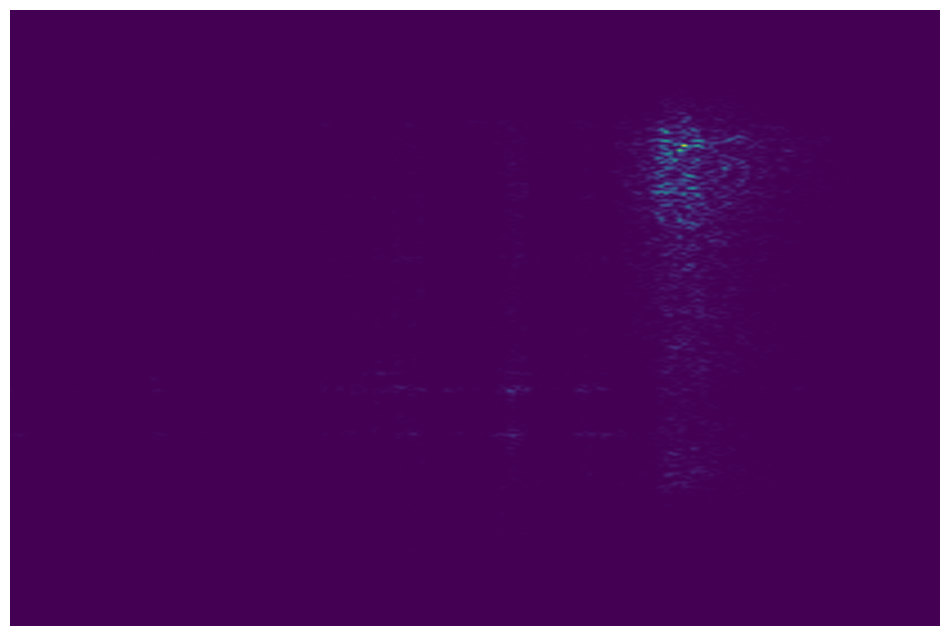

In [622]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import json
import xml.etree.ElementTree as ET

number_trace = 0
filtered_trace0 =  get_filtered(data.get_waveforms(number_trace)[0].T,
                                highpass_cut =.5,
                         #      bandpass_lowcut= .01,
                         #       bandpass_highcut =1,
                                band_filt=False)
frequencies, times, Sxx_0 = signal.spectrogram(filtered_trace0, 20,nfft = 2000,nperseg=400 , noverlap = 200,scaling = 'density')
dpi = 100
# Step 1: Plot the spectrogram
fig, ax = plt.subplots(figsize=(12, 8), dpi = dpi)

# Hide axes and spines
ax.axis('off')

# Plot the spectrogram
pcm = ax.pcolormesh(times, frequencies, Sxx_0, cmap='viridis', shading='gouraud')

# Step 2: Compute P and S arrival times
p_arrival = data.metadata.iloc[number_trace]['trace_P_spectral_start_arrival_sample'] / 20
s_arrival = data.metadata.iloc[number_trace]['trace_S_spectral_end_arrival_sample'] / 20

# Step 3: Draw the bounding box in data coordinates
ymin, ymax = ax.get_ylim()
bbox_x = p_arrival
bbox_width = s_arrival - p_arrival
bbox_y = ymin
bbox_height = ymax - ymin

rect = Rectangle((bbox_x, bbox_y), bbox_width, bbox_height,
                 linewidth=2, edgecolor='red', facecolor='none', alpha=0.6)


# Save the plot as PNG with the desired DPI, while capturing the pixel settings

output_file = 'plot.png'
plt.savefig(output_file, dpi=dpi)

# Display the plot (optional)
plt.show()

In [623]:
fig_width_px , fig_height_px  = fig.get_size_inches() *dpi

In [621]:
fig_width_px , fig_height_px

(1200.0, 800.0)

In [624]:
fig_width_px, fig_height_px = fig.get_size_inches() * dpi

In [625]:
xlim = ax.get_xlim()  # Get the x-axis limits (min, max)
ylim = ax.get_ylim()  # Get the y-axis limits (min, max)

In [626]:
min_x_disp =   ((p_arrival - xlim[0]) / (xlim[1] - xlim[0]) ) * fig_width_px

In [627]:
max_x_disp = min_x_disp +  ( (bbox_width / (xlim[1] - xlim[0]) )* fig_width_px)

In [628]:
min_y_disp = (bbox_y - ylim[0]) / (ylim[1] - ylim[0]) *fig_height_px

In [629]:
max_y_disp = bbox_height / (ylim[1] - ylim[0]) *fig_height_px

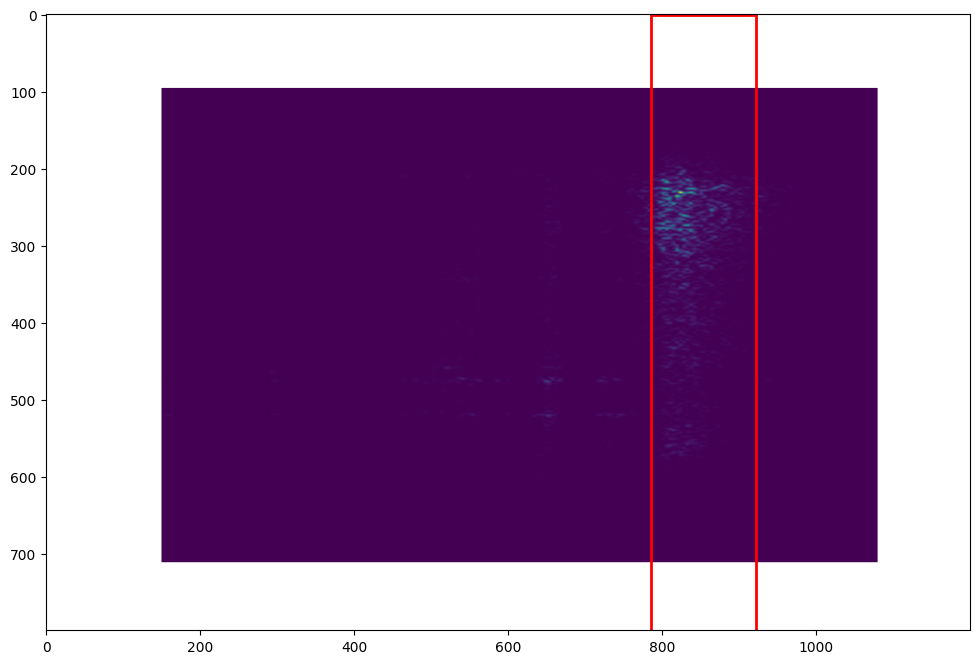

In [632]:
# prompt: display plot.png in the content folder, also draw a box on it

from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load the plot and add the bounding box
fig, ax = plt.subplots(figsize=(12, 8))  # Create a new figure and axes
img = plt.imread('plot.png')
ax.imshow(img)

# Define the coordinates of the bounding box (adjust these as needed)
rect = patches.Rectangle((min_x_disp, min_y_disp), max_x_disp - min_x_disp, max_y_disp,
                         linewidth=2, edgecolor='red', facecolor='none')
ax.add_patch(rect)
plt.show()


In [617]:
img_height

616

In [ ]:

# Define rectangle pixel coordinates
# (x, y) is the top-left corner and (width, height) are the rectangle dimensions in pixels
rect_x = 100  # X-coordinate of the top-left corner in pixels
rect_y = 200  # Y-coordinate of the top-left corner in pixels
rect_width = 300  # Width of the rectangle in pixels
rect_height = 150  # Height of the rectangle in pixels

# Create the figure and display the image
fig, ax = plt.subplots()
ax.imshow(img)
ax.axis('off')  # Turn off the axes

# Draw the rectangle using pixel coordinates
rect = Rectangle((rect_x, rect_y), rect_width, rect_height,
                 linewidth=2, edgecolor='red', facecolor='none')
ax.add_patch(rect)

# Display the annotated image
plt.show()


In [523]:
data_coords = np.array([
    [bbox_x, bbox_y],  # Bottom-left corner in data units
    [bbox_x + bbox_width, bbox_y + bbox_height]  # Top-right corner in data units
])

In [524]:
display_coords = ax.transData.transform(data_coords)

In [525]:
display_coords

array([[1516.54782609,  176.        ],
       [1727.4826087 , 1408.        ]])

In [526]:
(xmin_disp, ymin_disp), (xmax_disp, ymax_disp) = display_coords

In [532]:
ymin_pix = fig_height - ymin_disp
ymax_pix = fig_height - ymax_disp

In [547]:
ymin_pix = fig_height - ymin_disp
ymax_pix = fig_height - ymax_disp

# Bounding box in pixel units
bbox_coords_pixels = {
    'xmin': xmin_disp,
    'ymin': ymin_pix,
    'xmax': xmax_disp,
    'ymax': ymax_pix
}

print('Bounding box in pixel units:', bbox_coords_pixels)

Bounding box in pixel units: {'xmin': 1516.5478260869565, 'ymin': 1424.0, 'xmax': 1727.4826086956523, 'ymax': 192.0}


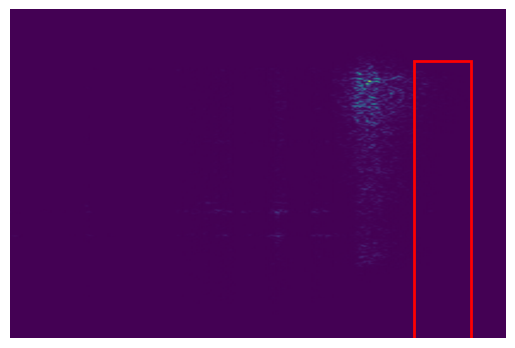

In [549]:
# prompt: Open the plot.png and show it. and display the bounding box on it

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

img = Image.open('plot.png')

# Get the bounding box coordinates from your previous code
# (Replace with your actual bbox_coords_pixels)
bbox_coords_pixels = {
    'xmin': xmin_disp,
    'ymin': ymin_pix,
    'xmax': xmax_disp,
    'ymax': ymax_pix
}

# Convert to integer values
xmin = int(bbox_coords_pixels['xmin'])
ymin = int(bbox_coords_pixels['ymin'])
xmax = int(bbox_coords_pixels['xmax'])
ymax = int(bbox_coords_pixels['ymax'])

# Create a figure and axis with no axes, ticks, or spines
fig, ax = plt.subplots()

# Ensure no axes, ticks, or grid
ax.axis('off')

# Display the image
ax.imshow(img)

# Create and add the rectangle patch for the bounding box
rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='red', facecolor='none')
ax.add_patch(rect)

# Show the plot without axes or ticks
plt.show()
plt.show()


In [ ]:

# Get the bounding box coordinates in pixel units
xmin = bbox_coords_pixels['xmin']
ymin = bbox_coords_pixels['ymin']
xmax = bbox_coords_pixels['xmax']
ymax = bbox_coords_pixels['ymax']

# Draw the bounding box
draw.rectangle([xmin, ymin, xmax, ymax], outline='red', width=2)

# Save the image with the bounding box overlay for inspection
image_with_bbox = 'plot_with_bbox.png'
image.save(image_with_bbox)

print(f'Bounding box drawn and saved to {image_with_bbox}')